# Part 1: Trend Analysis (R or Python)

#### 1. Analyse trend of goals per season. For example total goals per match, average goals per match.

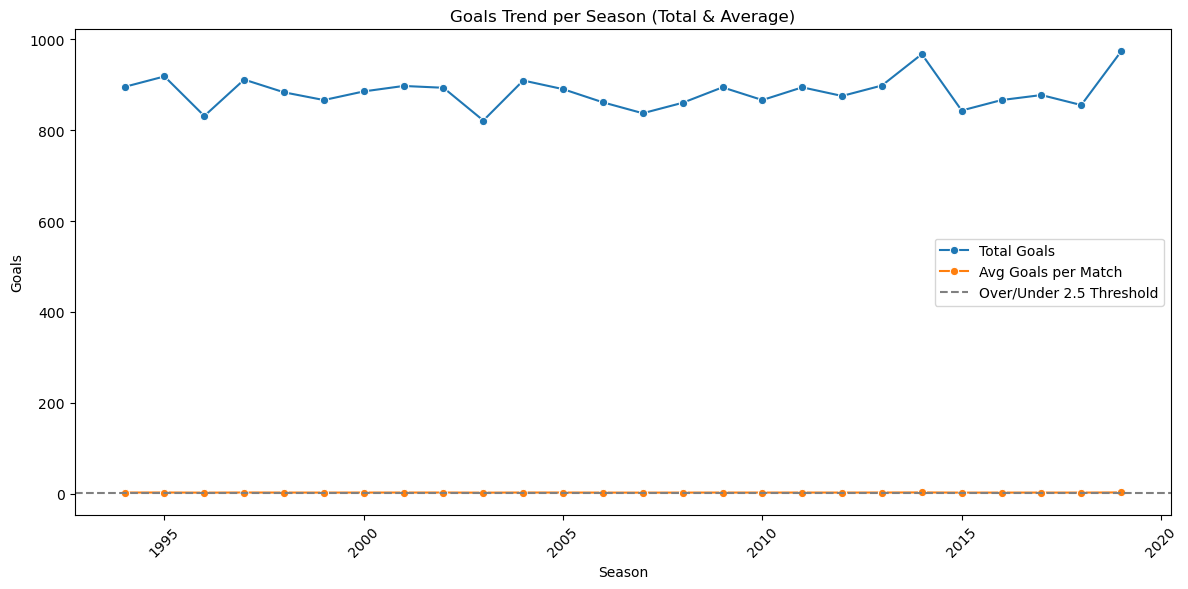

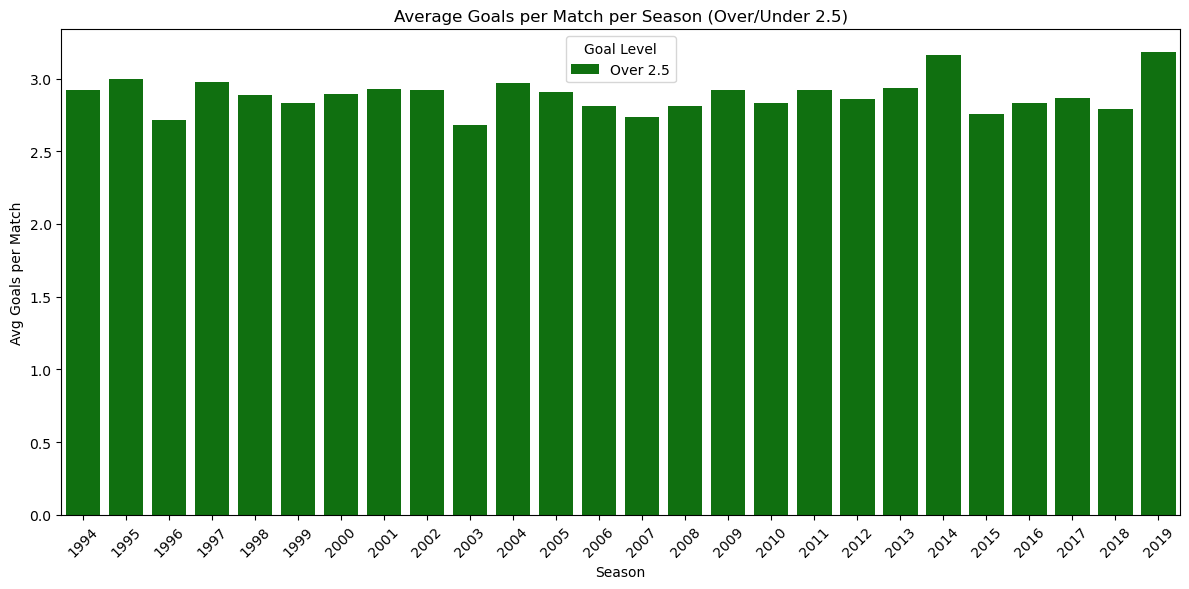

,SEASON,total_goals,total_matches,avg_goals_per_match,over_under
0,1994,895,306,2.924837,Over 2.5
1,1995,918,306,3.000000,Over 2.5
2,1996,831,306,2.715686,Over 2.5
3,1997,911,306,2.977124,Over 2.5
4,1998,883,306,2.885621,Over 2.5


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.backends.backend_pdf import PdfPages

df = pd.read_csv("bundesliga.csv")
#removing rows with missing goal data
df = df.dropna(subset=["FTHG", "FTAG"])
df["FTTG"] = df["FTHG"] + df["FTAG"]

season_stats = df.groupby("SEASON").agg(
    total_goals=("FTTG", "sum"),
    total_matches=("FTTG", "count")
).reset_index()
season_stats["avg_goals_per_match"] = season_stats["total_goals"] / season_stats["total_matches"]
season_stats["over_under"] = season_stats["avg_goals_per_match"].apply(lambda x: "Over 2.5" if x > 2.5 else "Under 2.5")


#total and average goals per match by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=season_stats, x="SEASON", y="total_goals", marker='o', label="Total Goals")
sns.lineplot(data=season_stats, x="SEASON", y="avg_goals_per_match", marker='o', label="Avg Goals per Match")
plt.axhline(2.5, color='gray', linestyle='--', label="Over/Under 2.5 Threshold")
plt.title("Goals Trend per Season (Total & Average)")
plt.xlabel("Season")
plt.ylabel("Goals")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#goal distribution per season with Over/Under coloring
plt.figure(figsize=(12, 6))
sns.barplot(data=season_stats, x="SEASON", y="avg_goals_per_match", hue="over_under", dodge=False, palette={"Over 2.5": "green", "Under 2.5": "red"})
plt.title("Average Goals per Match per Season (Over/Under 2.5)")
plt.xlabel("Season")
plt.ylabel("Avg Goals per Match")
plt.xticks(rotation=45)
plt.legend(title="Goal Level")
plt.tight_layout()
plt.show()


season_stats.head()

#### 2. Goal Distribution Per Season. Use appropriate type of graphs for goals per match, year-wise. Color-code by whether average is above or below 2.5 (over/under bet threshold).

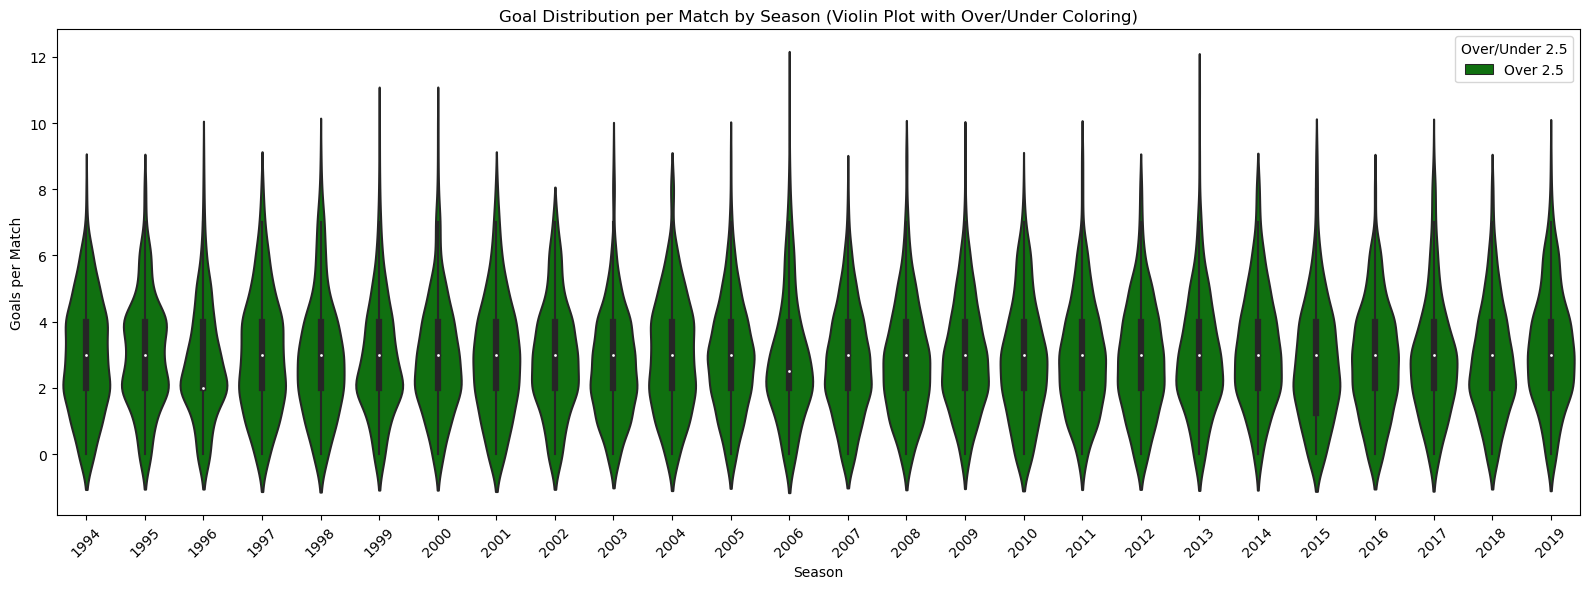

In [2]:
match_goals = df[["SEASON", "FTHG", "FTAG", "FTTG"]].copy()
match_goals = match_goals.merge(season_stats[["SEASON", "over_under"]], on="SEASON", how="left")

plt.figure(figsize=(16, 6))
sns.violinplot(data=match_goals, x="SEASON", y="FTTG", hue="over_under",
               palette={"Over 2.5": "green", "Under 2.5": "red"})
plt.title("Goal Distribution per Match by Season (Violin Plot with Over/Under Coloring)")
plt.xlabel("Season")
plt.ylabel("Goals per Match")
plt.xticks(rotation=45)
plt.legend(title="Over/Under 2.5", loc="upper right")
plt.tight_layout()
plt.show()


#### 3. Create line charts for each season. Visualize trend of goals for each team that played in that season. Highlight only Bayern Munchen with red color. Rest should be gray. Add appropriate title that will contain information about season and total scored goals. Add footnote mentioning total number of goals scored by Bayern Munchen for that season. Save all graphs in pdf.

In [3]:
df["FTTG"] = df["FTHG"] + df["FTAG"]
seasons = df["SEASON"].unique()
seasons.sort()

pdf_path = "bayern_munchen_trend_by_season.pdf"
pdf = PdfPages(pdf_path)

for season in seasons:
    season_df = df[df["SEASON"] == season]
    matches = []
    for _, row in season_df.iterrows():
        matches.append({"Team": row["HOMETEAM"], "Goals": row["FTHG"]})
        matches.append({"Team": row["AWAYTEAM"], "Goals": row["FTAG"]})
    team_goals = pd.DataFrame(matches)
    team_goals["MatchNumber"] = team_goals.groupby("Team").cumcount() + 1
    team_goals["CumulativeGoals"] = team_goals.groupby("Team")["Goals"].cumsum()

    plt.figure(figsize=(12, 6))
    bayern_goals = 0

    for team in team_goals["Team"].unique():
        data = team_goals[team_goals["Team"] == team]
        if team == "Bayern Munich":
            plt.plot(data["MatchNumber"], data["CumulativeGoals"], color="red", label="Bayern Munchen")
            bayern_goals = data["Goals"].sum()
        else:
            plt.plot(data["MatchNumber"], data["CumulativeGoals"], color="gray", alpha=0.4)

    plt.title(f"Goal Trend per Team – {season} Season (Total League Goals: {int(season_df['FTTG'].sum())})")
    plt.xlabel("Match Number")
    plt.ylabel("Cumulative Goals")
    plt.figtext(0.5, 0.01, f"Bayern Munchen scored {int(bayern_goals)} goals in {season}", ha="center", fontsize=9)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

pdf.close()
print(f"Saved the file as {pdf_path}")

Saved the file as bayern_munchen_trend_by_season.pdf


# Part 2: Home Advantage Deconstructed (R or Python)

#### 1. Create Heatmap of Home vs. Away Wins per Team per Season.

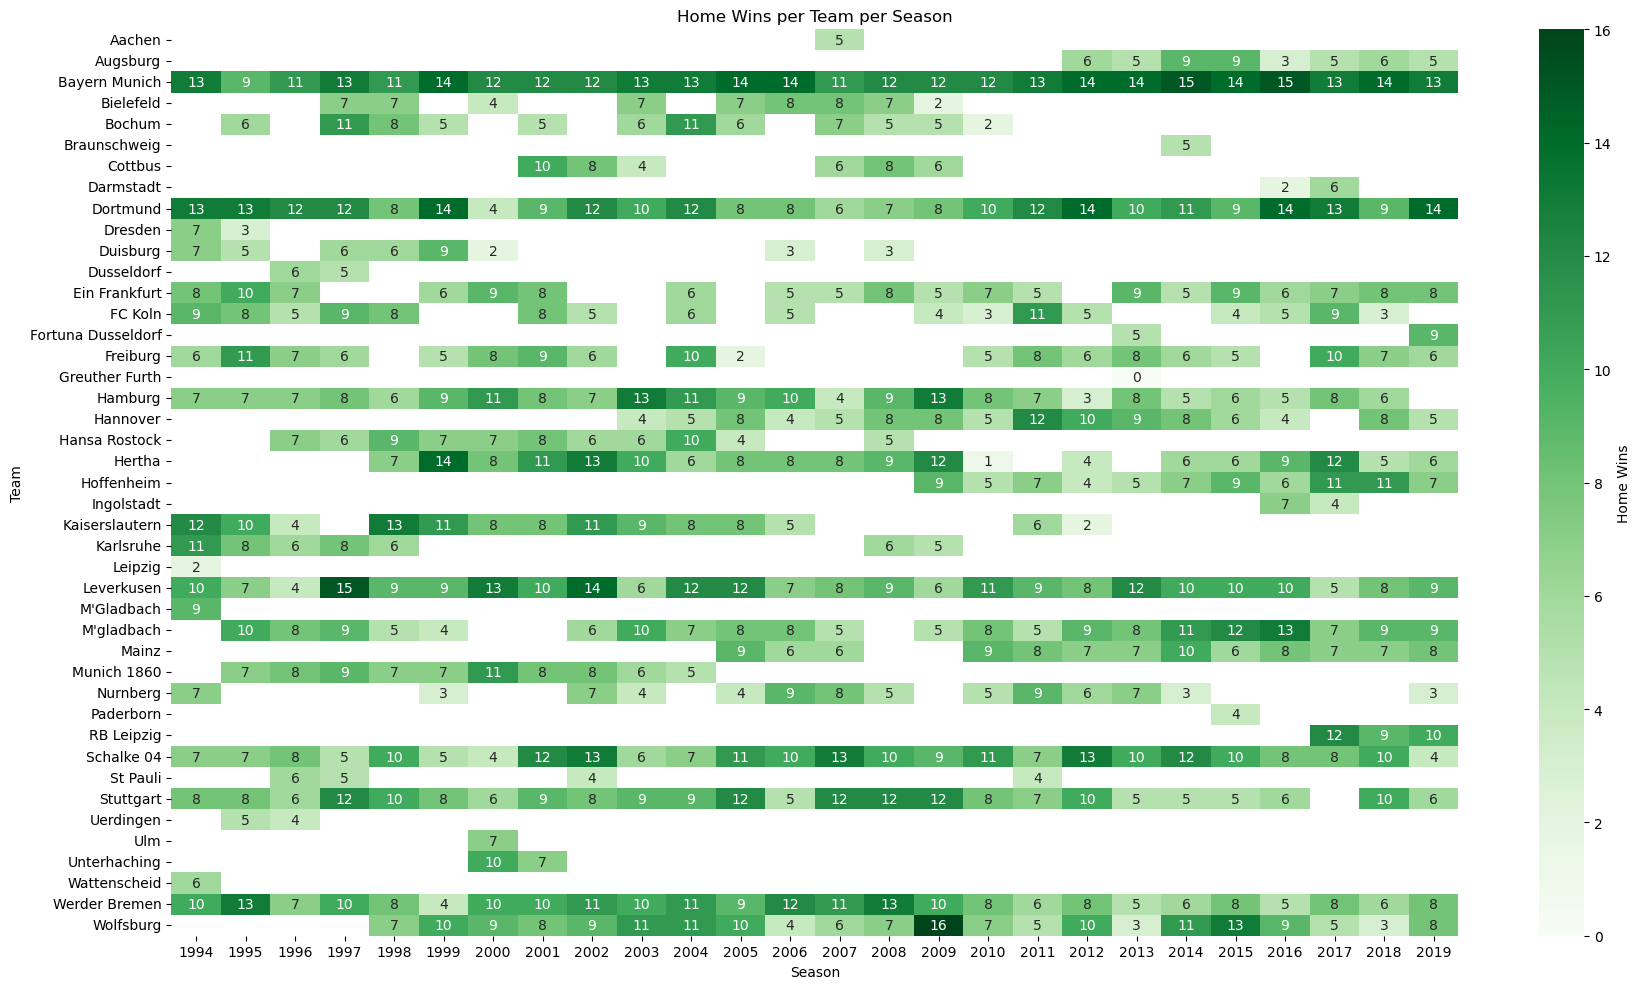

In [4]:
df["FTR"] = df.apply(
    lambda row: "H" if row["FTHG"] > row["FTAG"] else "A" if row["FTHG"] < row["FTAG"] else "D",
    axis=1
)

valid_results = df[df["FTR"].isin(["H", "A"])].copy()

home_wins = valid_results[valid_results["FTR"] == "H"]
away_wins = valid_results[valid_results["FTR"] == "A"]
home_win_counts = home_wins.groupby(["SEASON", "HOMETEAM"]).size().reset_index(name="HomeWins")
away_win_counts = away_wins.groupby(["SEASON", "AWAYTEAM"]).size().reset_index(name="AwayWins")

team_wins = pd.merge(
    home_win_counts,
    away_win_counts,
    left_on=["SEASON", "HOMETEAM"],
    right_on=["SEASON", "AWAYTEAM"],
    how="outer"
)

team_wins["Team"] = team_wins["HOMETEAM"].combine_first(team_wins["AWAYTEAM"])
team_wins["SEASON"] = team_wins["SEASON"]
team_wins["HomeWins"] = team_wins["HomeWins"].fillna(0)
team_wins["AwayWins"] = team_wins["AwayWins"].fillna(0)
team_wins = team_wins[["SEASON", "Team", "HomeWins", "AwayWins"]]

heatmap_home = team_wins.pivot(index="Team", columns="SEASON", values="HomeWins")

plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_home, annot=True, fmt=".0f", cmap="Greens", cbar_kws={'label': 'Home Wins'})
plt.title("Home Wins per Team per Season")
plt.xlabel("Season")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

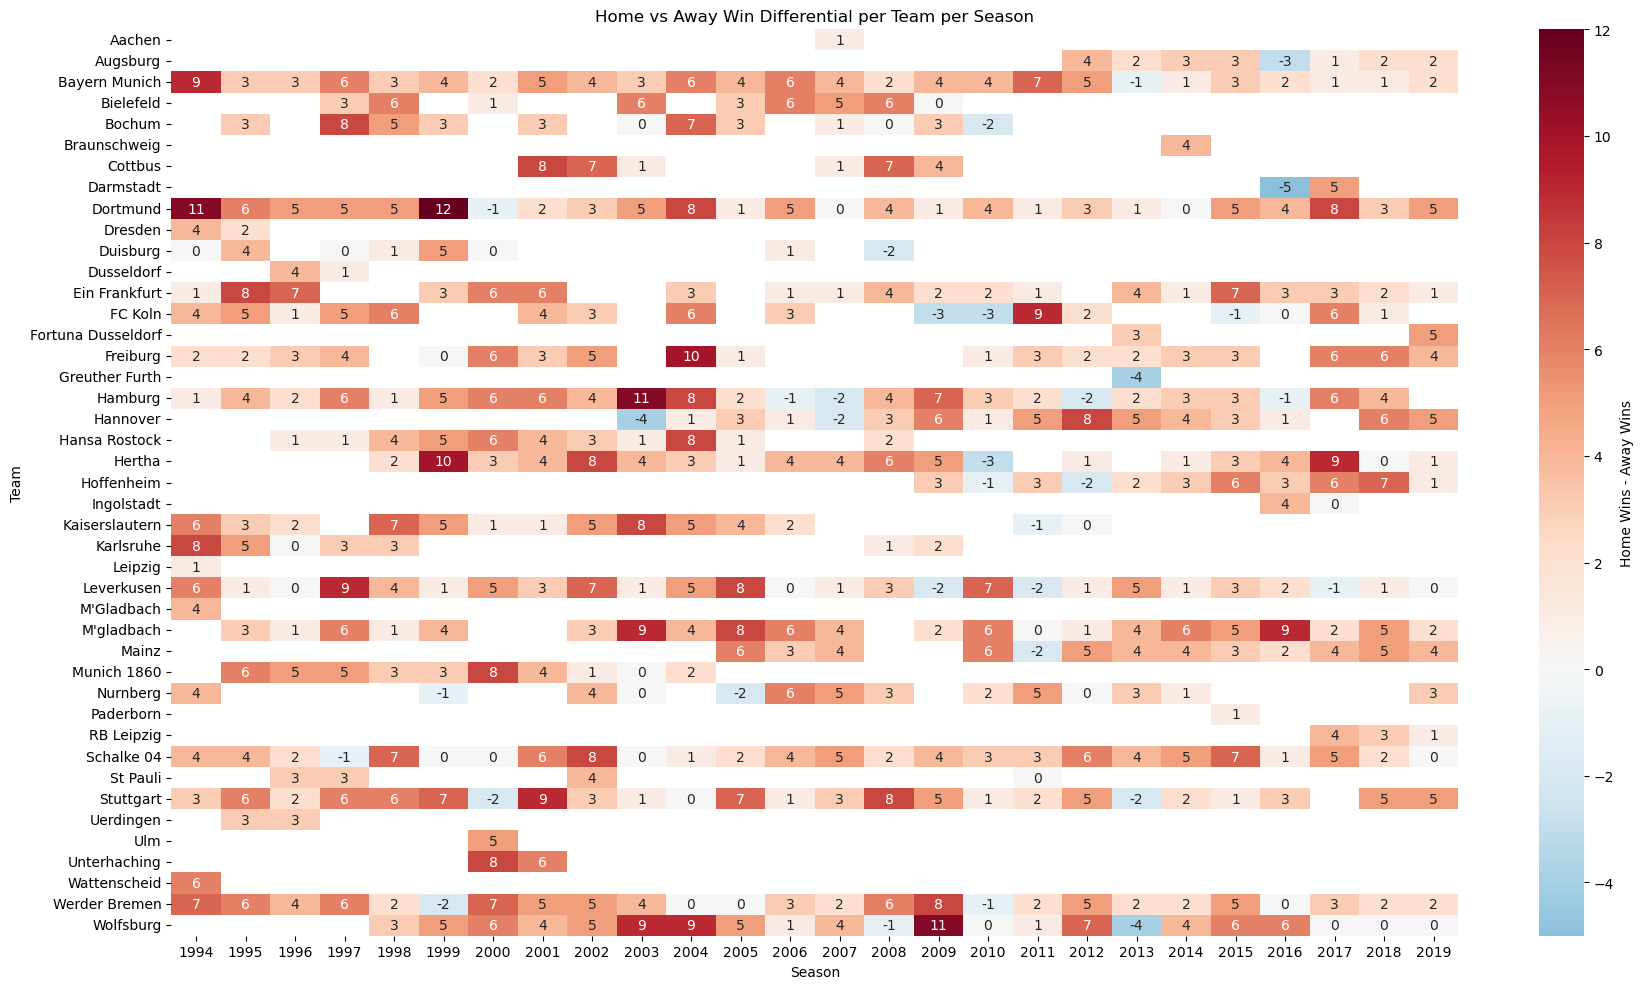

In [5]:
team_wins["WinDiff"] = team_wins["HomeWins"] - team_wins["AwayWins"]
heatmap_diff = team_wins.pivot(index="Team", columns="SEASON", values="WinDiff")

plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_diff, annot=True, fmt=".0f", center=0, cmap="RdBu_r", cbar_kws={'label': 'Home Wins - Away Wins'})
plt.title("Home vs Away Win Differential per Team per Season")
plt.xlabel("Season")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

#### 2. Point Differential Density: Create visualizations that will show difference per team for home and away game wins.

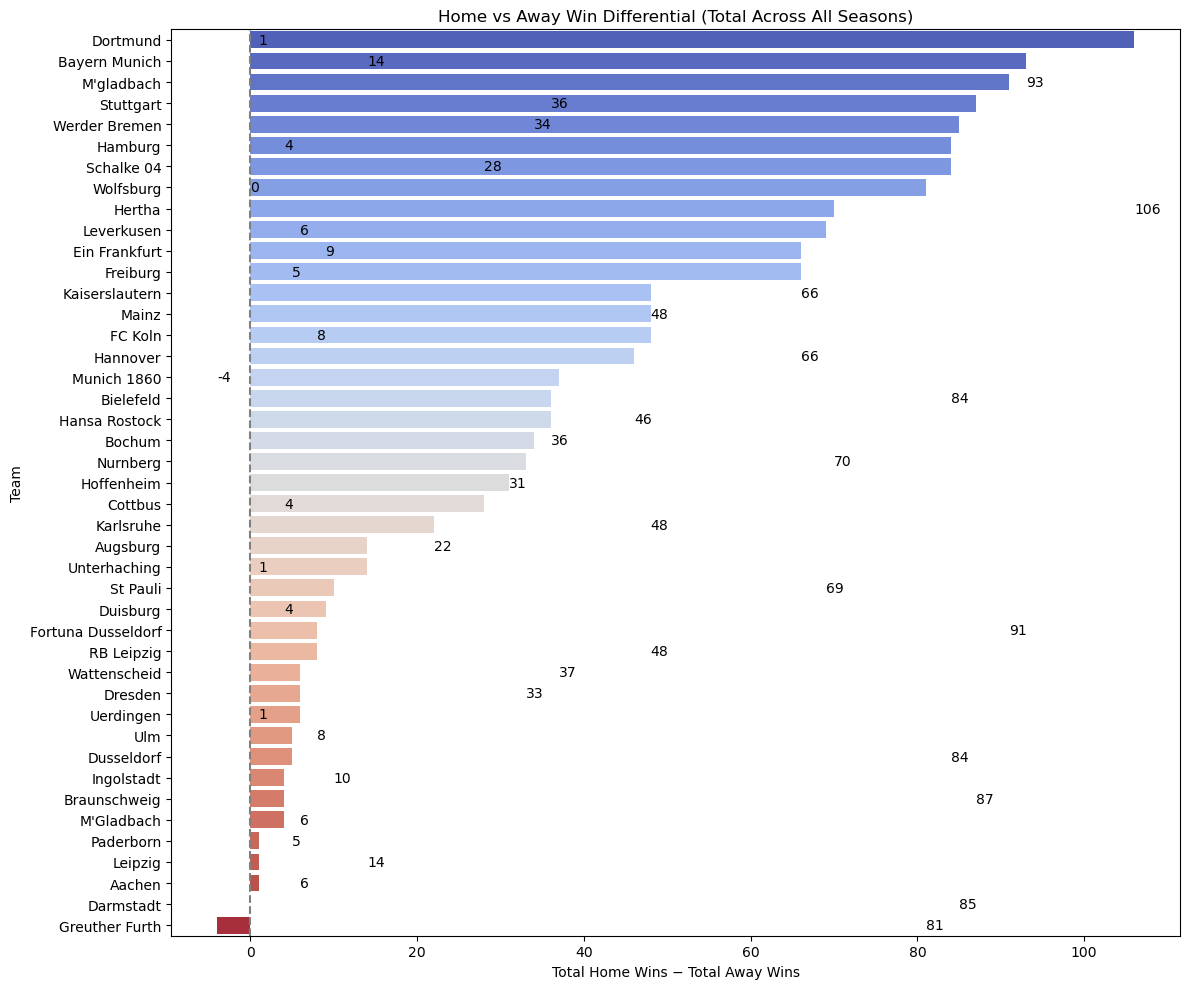

In [6]:
win_diff_summary = team_wins.groupby("Team").agg({
    "HomeWins": "sum",
    "AwayWins": "sum"
}).reset_index()

win_diff_summary["WinDifference"] = win_diff_summary["HomeWins"] - win_diff_summary["AwayWins"]
win_diff_summary = win_diff_summary.sort_values(by="WinDifference", ascending=False)

plt.figure(figsize=(12, 10))
bars = sns.barplot(data=win_diff_summary, y="Team", x="WinDifference", palette="coolwarm", dodge=False)

for i, row in win_diff_summary.iterrows():
    bars.text(row["WinDifference"], i, f"{int(row['WinDifference'])}", color="black", va="center")

plt.axvline(0, color="gray", linestyle="--")
plt.title("Home vs Away Win Differential (Total Across All Seasons)")
plt.xlabel("Total Home Wins − Total Away Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


# Part 3

#### 1. Team Trajectories and Volatility
- Seasonal Position Trajectories
- Line plots showing seasonal ranks for top 6 teams.
- Annotate title-winning seasons.

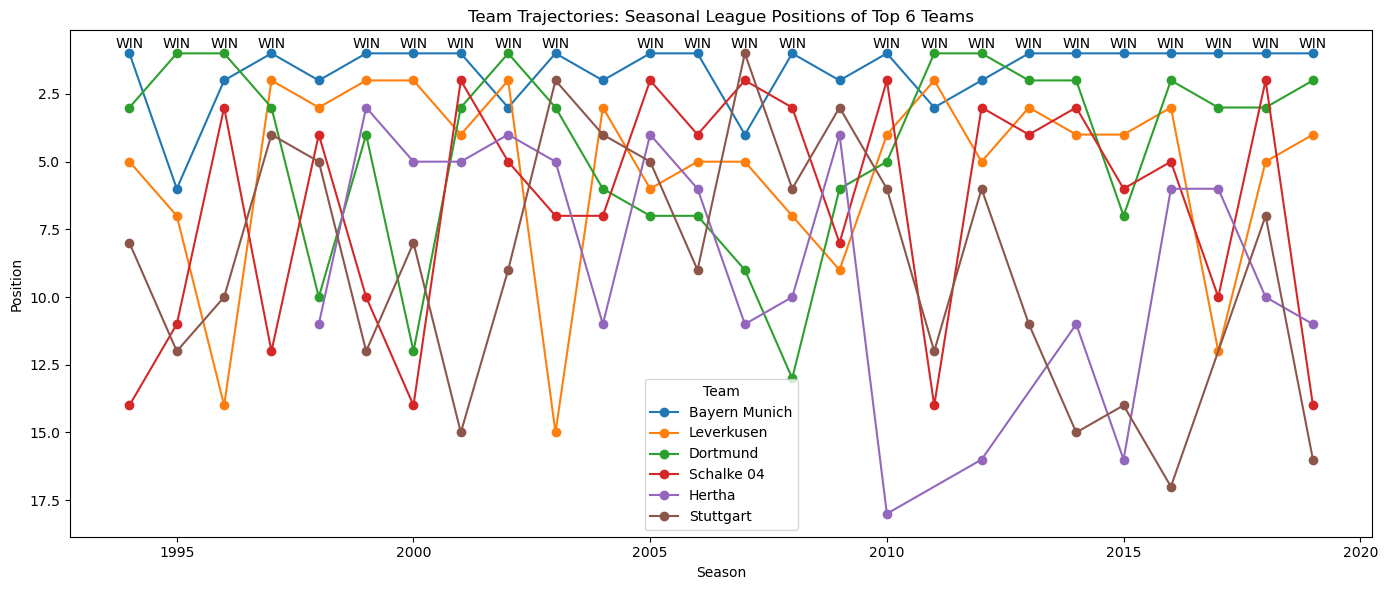

In [7]:
df2 = pd.read_csv("bundesliga2.csv")

df2.columns = df2.columns.str.strip().str.upper()
df_positions = df2[["SEASON", "TEAM", "POSITION"]].dropna()
df_positions["POSITION"] = pd.to_numeric(df_positions["POSITION"], errors="coerce")

top_teams = df_positions[df_positions["POSITION"] <= 6]["TEAM"].value_counts().head(6).index.tolist()
df_top6 = df_positions[df_positions["TEAM"].isin(top_teams)]

plt.figure(figsize=(14, 6))
for team in top_teams:
    team_data = df_top6[df_top6["TEAM"] == team]
    plt.plot(team_data["SEASON"], team_data["POSITION"], marker='o', label=team)
    win_seasons = team_data[team_data["POSITION"] == 1]
    for _, row in win_seasons.iterrows():
        plt.annotate("WIN", (row["SEASON"], row["POSITION"] - 0.2), ha="center", fontsize=10)

plt.gca().invert_yaxis()   
plt.title("Team Trajectories: Seasonal League Positions of Top 6 Teams")
plt.xlabel("Season")
plt.ylabel("Position")
plt.legend(title="Team")
plt.tight_layout()
plt.show()

#### 2. Volatility Index
- For each team, calculate standard deviation of final rank over all seasons.
- Use a bar chart with conditional coloring (e.g., red = unstable, green = consistent).
- Add text labels above each bar with exact values.

In [ ]:
volatility = df_positions.groupby("TEAM")["POSITION"].std().reset_index()
volatility.columns = ["TEAM", "STD_DEV"]
volatility = volatility.dropna().sort_values("STD_DEV", ascending=True)

threshold = volatility["STD_DEV"].median()
volatility["STABILITY"] = volatility["STD_DEV"].apply(lambda x: "Consistent" if x < threshold else "Unstable")

plt.figure(figsize=(14, 6))
palette = {"Consistent": "green", "Unstable": "red"}
bars = sns.barplot(data=volatility, x="TEAM", y="STD_DEV", hue="STABILITY", dodge=False, palette=palette)

for index, row in volatility.iterrows():
    bars.text(index, row["STD_DEV"] + 0.1, f"{row['STD_DEV']:.2f}", color="black", ha='center')

plt.title("Volatility Index: Std Dev of Final League Positions per Team")
plt.xlabel("Team")
plt.ylabel("Standard Deviation of Final Rank")
plt.xticks(rotation=45)
plt.legend(title="Stability")
plt.tight_layout()
plt.show()

# Part 4

#### 1. Head-to-Head Matrix for Selected Rivalries
- Select 5 key rivalries more info click here .
- Create a facet grid of win/draw/loss bar charts per rivalry.
- Annotate biggest win margins.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_matches = df.copy()

df_matches["HOMETEAM"] = df_matches["HOMETEAM"].str.strip()
df_matches["AWAYTEAM"] = df_matches["AWAYTEAM"].str.strip()

rivalries = [
    ("Bayern Munich", "Dortmund"),
    ("Hamburg", "Werder Bremen"),
    ("Ein Frankfurt", "Mainz"),
    ("FC Koln", "Leverkusen"),
    ("Bielefeld", "Bochum"),
]

rivalry_data = []
for team1, team2 in rivalries:
    subset = df_matches[
        ((df_matches["HOMETEAM"] == team1) & (df_matches["AWAYTEAM"] == team2)) |
        ((df_matches["HOMETEAM"] == team2) & (df_matches["AWAYTEAM"] == team1))
    ].copy()
    if not subset.empty:
        subset["Rivalry"] = f"{team1} vs {team2}"
        subset["Team1"] = team1
        subset["Team2"] = team2
        rivalry_data.append(subset)

rivalry_df = pd.concat(rivalry_data)

def result_from_team1(row):
    team1 = row["Team1"]
    is_home = row["HOMETEAM"] == team1
    team1_goals = row["FTHG"] if is_home else row["FTAG"]
    team2_goals = row["FTAG"] if is_home else row["FTHG"]
    if team1_goals > team2_goals:
        return "Win"
    elif team1_goals < team2_goals:
        return "Loss"
    else:
        return "Draw"

rivalry_df["Perspective"] = rivalry_df.apply(result_from_team1, axis=1)

def margin_from_team1(row):
    team1 = row["Team1"]
    is_home = row["HOMETEAM"] == team1
    team1_goals = row["FTHG"] if is_home else row["FTAG"]
    team2_goals = row["FTAG"] if is_home else row["FTHG"]
    return abs(team1_goals - team2_goals)

rivalry_df["GoalMargin"] = rivalry_df.apply(margin_from_team1, axis=1)

max_margins = rivalry_df.sort_values("GoalMargin", ascending=False).groupby("Rivalry").first().reset_index()

g = sns.catplot(
    data=rivalry_df,
    x="Perspective",
    kind="count",
    col="Rivalry",
    col_wrap=2,
    palette="Set2",
    height=4,
    aspect=1
)

g.fig.suptitle("Head-to-Head Results for Classic Bundesliga Rivalries (Team1 Perspective)", y=1.08)

for ax, title in zip(g.axes.flatten(), g.col_names):
    data = rivalry_df[rivalry_df["Rivalry"] == title]
    biggest = max_margins[max_margins["Rivalry"] == title].iloc[0]
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f"{int(height)}", (bar.get_x() + bar.get_width() / 2, height),
                    ha="center", va="bottom")
    ax.annotate(
        f"Biggest win: {biggest['Team1']} {int(biggest['FTHG'])}–{int(biggest['FTAG'])} {biggest['AWAYTEAM']}" if biggest["HOMETEAM"] == biggest["Team1"]
        else f"Biggest win: {biggest['Team1']} {int(biggest['FTAG'])}–{int(biggest['FTHG'])} {biggest['HOMETEAM']}",
        xy=(0.5, -0.25), xycoords='axes fraction',
        ha='center', fontsize=8, color='dimgray'
    )

plt.tight_layout()
plt.show()


#### 2. Upset Visualizer
- Define “upset” as a team >8 places below beating a top-5 team.
- Scatterplot of upsets: x-axis = rank difference, y-axis = goal difference.
- Encode team colors; highlight and label famous upsets

In [ ]:
df_table = pd.read_csv("bundesliga2.csv")
df_table.columns = df_table.columns.str.strip().str.upper()
df_table["TEAM"] = df_table["TEAM"].str.strip()

df_matches = df.copy()
df_matches["HOMETEAM"] = df_matches["HOMETEAM"].str.strip()
df_matches["AWAYTEAM"] = df_matches["AWAYTEAM"].str.strip()
df_matches["FTTG"] = df_matches["FTHG"] + df_matches["FTAG"]

merged = df_matches.merge(df_table[["SEASON", "TEAM", "POSITION"]], 
                          left_on=["SEASON", "HOMETEAM"], right_on=["SEASON", "TEAM"], how="left") \
                   .rename(columns={"POSITION": "HomeRank"}).drop(columns="TEAM")

merged = merged.merge(df_table[["SEASON", "TEAM", "POSITION"]], 
                      left_on=["SEASON", "AWAYTEAM"], right_on=["SEASON", "TEAM"], how="left") \
               .rename(columns={"POSITION": "AwayRank"}).drop(columns="TEAM")

def upset_info(row):
    if row["FTHG"] > row["FTAG"]:
        winner = row["HOMETEAM"]
        loser = row["AWAYTEAM"]
        rank_diff = row["AwayRank"] - row["HomeRank"]
        goal_diff = row["FTHG"] - row["FTAG"]
    elif row["FTAG"] > row["FTHG"]:
        winner = row["AWAYTEAM"]
        loser = row["HOMETEAM"]
        rank_diff = row["HomeRank"] - row["AwayRank"]
        goal_diff = row["FTAG"] - row["FTHG"]
    else:
        return pd.Series([None, None, None, None])
    return pd.Series([winner, loser, rank_diff, goal_diff])

merged[["Winner", "Loser", "RankDiff", "GoalDiff"]] = merged.apply(upset_info, axis=1)

upsets = merged[(merged["RankDiff"] >= 8) & merged["Winner"].notnull()].copy()

plt.figure(figsize=(12, 7))
sns.scatterplot(data=upsets, x="RankDiff", y="GoalDiff", hue="Winner", legend=False, palette="tab10")

famous_upsets = upsets.sort_values(by="GoalDiff", ascending=False).head(5)
for _, row in famous_upsets.iterrows():
    plt.annotate(
        f"{row['Winner']} vs {row['Loser']} ({int(row['GoalDiff'])} goals)",
        xy=(row["RankDiff"], row["GoalDiff"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha='left',
        fontsize=8,
        color='darkred'
    )

plt.title("Upset Visualizer: Wins by Teams Ranked 8+ Places Lower than Opponent")
plt.xlabel("Rank Difference (Loser Rank - Winner Rank)")
plt.ylabel("Goal Difference")
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 5: Overall performance (R and Python)

####  Define unique color for each team per season. For each season create horizontal bar plot using totalnumber of points. Highlighting the winner with the unique color that you assigned to it. Save all graphs in pdf. Redo the same task in python. But instead of total points use goal difference. Use same logic for colorsas in first part. 

In [ ]:
df_table = df_table[["SEASON", "TEAM", "POINTS", "DIFF"]].dropna()
unique_teams = df_table["TEAM"].unique()
team_palette = dict(zip(unique_teams, sns.color_palette("tab20", len(unique_teams))))

pdf_points = PdfPages("points_by_season.pdf")
print(f"Saved the file as {pdf_points}")


for season in sorted(df_table["SEASON"].unique()):
    season_df = df_table[df_table["SEASON"] == season].sort_values("POINTS", ascending=True)
    winner_team = season_df.sort_values("POINTS", ascending=False).iloc[0]["TEAM"]

    plt.figure(figsize=(10, 8))
    plt.barh(
        y=season_df["TEAM"],
        width=season_df["POINTS"],
        color=[team_palette[team] if team == winner_team else "lightgray" for team in season_df["TEAM"]]
    )
    plt.title(f"Total Points per Team - Season {season} (Winner: {winner_team})")
    plt.xlabel("Points")
    plt.ylabel("Team")
    plt.tight_layout()
    pdf_points.savefig()
    plt.close()

pdf_points.close()

pdf_diff = PdfPages("goal_difference_by_season.pdf")
print(f"Saved the file as {pdf_diff}")

for season in sorted(df_table["SEASON"].unique()):
    season_df = df_table[df_table["SEASON"] == season].sort_values("DIFF", ascending=True)
    winner_team = season_df.sort_values("DIFF", ascending=False).iloc[0]["TEAM"]

    plt.figure(figsize=(10, 8))
    plt.barh(
        y=season_df["TEAM"],
        width=season_df["DIFF"],
        color=[team_palette[team] if team == winner_team else "lightgray" for team in season_df["TEAM"]]
    )
    plt.title(f"Goal Difference per Team - Season {season} (Winner: {winner_team})")
    plt.xlabel("Goal Difference")
    plt.ylabel("Team")
    plt.tight_layout()
    pdf_diff.savefig()
    plt.close()

pdf_diff.close()

# Part 6. Monte Carlo simulation. (R or Python)

#### Use Monte Carlo simulation to predict how many goals will Bayern Munchen score for next 10 seasons. Repeat the same for Bayer Leverkusen and Borusia Dortmund. Compare results using appropriate visualization technique.

In [ ]:
target_teams = ["Bayern Munich", "Leverkusen", "Dortmund"]

goal_records = []
for team in target_teams:
    team_home = df[df["HOMETEAM"] == team][["SEASON", "FTHG"]].groupby("SEASON").sum().rename(columns={"FTHG": "Goals"})
    team_away = df[df["AWAYTEAM"] == team][["SEASON", "FTAG"]].groupby("SEASON").sum().rename(columns={"FTAG": "Goals"})
    team_total = team_home.add(team_away, fill_value=0)
    team_total["Team"] = team
    goal_records.append(team_total.reset_index())

historical_goals = pd.concat(goal_records)

simulated_data = []
for team in target_teams:
    team_goals = historical_goals[historical_goals["Team"] == team]["Goals"]
    mu, sigma = team_goals.mean(), team_goals.std()
    simulated_goals = np.random.normal(loc=mu, scale=sigma, size=10).round().astype(int)
    for i, goals in enumerate(simulated_goals, start=1):
        simulated_data.append({"Team": team, "Season": f"Sim_{i}", "Goals": goals})

simulated_df = pd.DataFrame(simulated_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=simulated_df, x="Season", y="Goals", hue="Team", marker='o')
plt.title("Monte Carlo Simulation: Predicted Goals for Next 10 Seasons")
plt.ylabel("Predicted Total Goals")
plt.xlabel("Simulated Season")
plt.tight_layout()
plt.show()